In [1]:
# query = decoder hidden
# values = encoder output

In [1]:
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib
import time

In [2]:
from gp_kernels import *
from gp_priors import *
from gp_plots import *

In [17]:
from data_generation import *
from batch_creator import *

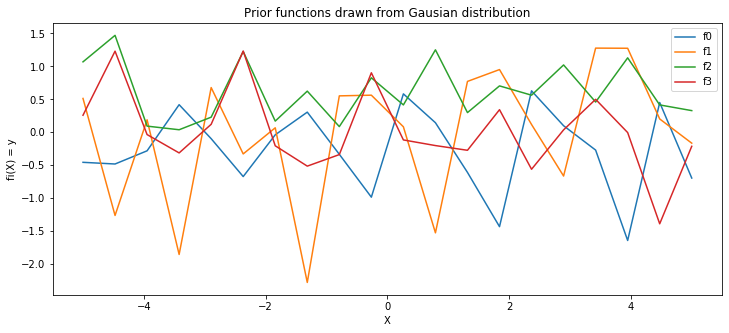

In [4]:
plot_gp_prior(4, n=20)

In [5]:
eng_tr, eng_te,  fren_tr, fren_te, y_fren_tr, y_fren_te = \
data_generator_for_gp_mimick(10000, 20, 
                             rbf_kernel, tr_percent=0.8)

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
#         self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self, batch_sz):
        return tf.zeros((batch_sz, self.enc_units))

In [7]:
encoder = Encoder(32)

In [8]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_out):
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)

        score = self.V(tf.nn.tanh(
            self.W1(decoder_hidden_with_time_axis) + self.W2(encoder_out)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * encoder_out
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [9]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(1)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, dec_inp, dec_hidden, enc_output):
        context_vector, attention_weights = self.attention(dec_hidden, enc_output)

        x = tf.concat([tf.expand_dims(context_vector, 1), 
                       tf.expand_dims(dec_inp, 1)], 
                      axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [10]:
decoder = Decoder(32)

In [11]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    loss_ = tf.keras.losses.mean_squared_error(real, pred)
    return tf.reduce_mean(loss_)

In [12]:
# french_tr is the input to decoder
@tf.function
def train_step(eng_tr, fren_tr, y_fren_tr, init_enc_hidden):

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(eng_tr, init_enc_hidden)
        dec_hidden = enc_hidden
        # basically same behavior as reshape
        dec_input = tf.expand_dims(fren_tr, 1)
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss = loss_function(y_fren_tr, predictions)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    batch_loss(loss)

In [13]:
@tf.function
def test_step(eng_te, fren_te, y_fren_te, batch_s):
    init_enc_hidden = encoder.initialize_hidden_state(batch_s)
    enc_output, enc_hidden = encoder(eng_te, init_enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims(fren_te, 1)
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss = loss_function(y_fren_te, predictions)
    test_loss(loss)

In [14]:
batch_loss = tf.keras.metrics.Mean(name='batch_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [15]:
tf.keras.backend.set_floatx('float32')

In [18]:
EPOCHS = 80

for epoch in range(EPOCHS):
    start = time.time()

    batch_loss.reset_states()


    init_enc_hidden = encoder.initialize_hidden_state(128)

    for i in range(1000):
        b_eng_tr, b_fren_tr, b_y_fren_tr, _ = create_batch_gp_mim(eng_tr, fren_tr, y_fren_tr)
        train_step(b_eng_tr, b_fren_tr, b_y_fren_tr, init_enc_hidden)
        
        
        if i % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   i,
                                                   batch_loss.result()))
            test_step(eng_te, fren_te, y_fren_te, eng_te.shape[0])
        
            print('Epoch {} Batch {} test Loss {:.4f}'.format(epoch + 1,
                                                   i,
                                                   test_loss.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1 Batch 0 

KeyboardInterrupt: 

In [ ]:
encoder.trainable_variables